In [1]:
import os
from tqdm import tqdm
import math

In [2]:
data_dir = "./data"
downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

In [3]:
# Download ADE20K scene parsing dataset
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip -O {downloads_dir}/scene_parsing.zip
# !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip -O {downloads_dir}/scene_parsing_test.zip

!unzip -q -o {downloads_dir}'/scene_parsing.zip' -d {datasets_dir}
# !unzip -q -o {downloads_dir}'/scene_parsing_test.zip' -d {datasets_dir}
!rm -rf {downloads_dir}

--2022-05-08 17:01:22--  http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 967382037 (923M) [application/zip]
Saving to: ‘./data/downloads/scene_parsing.zip’

./data/downloads/sc 100%[===================>] 922.57M  34.3MB/s    in 27s     

2022-05-08 17:01:50 (33.9 MB/s) - ‘./data/downloads/scene_parsing.zip’ saved [967382037/967382037]



In [4]:
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00001701.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00001701.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00003020.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00003020.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00008455.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00008455.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00013508.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00013508.png"

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars

from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


## Data Loader

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import glob

import torch.utils.data as data
import glob

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, split="training"):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'images', split, '*.jpg')))
        self.mask_files =  sorted(glob.glob(os.path.join(folder_path,'annotations', split, '*.png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = PIL.Image.open(img_path)
        mask = PIL.Image.open(mask_path)

        image = np.asarray(transforms.Resize([512,512])(image))
        image = transforms.ToTensor()(image)
        mask = np.asarray(transforms.Resize([512,512])(mask))
        mask = mask.astype(np.int64)
        
        return image, torch.from_numpy(mask)#torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files) // 4

In [7]:
folder_path = "/content/data/datasets/ADEChallengeData2016/"
train_data = DataLoaderSegmentation(folder_path)
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers = 2)
print("Check how many steps in one training epoch: ", len(train_data_loader))

Check how many steps in one training epoch:  1263


In [8]:
validation_data = DataLoaderSegmentation(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=True, num_workers = 2)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  125


In [9]:
img, seg = next(iter(train_data_loader))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

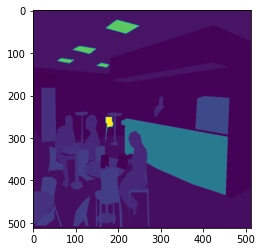

In [10]:
plt.imshow(seg[7,:,:])

## Visualize the First Batch with Edge

In [7]:
def visualize_first_n(batch_img, batch_seg, n):
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(batch_img[i,:,:,:].permute((1,2,0)))
    ax.axis('off')
    ax.set_title('image {}'.format(i+1))
    i += 1

  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    if ax is None:
        break
    seg_mask = np.zeros((512,512,3))
    for k in range(512):
      for j  in range(512):
        seg_mask[k,j,:] = PALETTE[batch_seg[i,k,j].item()]/255.0
    ax.imshow(seg_mask)
    ax.axis('off')
    ax.set_title('annotation {}'.format(i+1))
    i += 1

PALETTE = torch.tensor([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20], [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0], [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255], [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0], [92, 0, 255], [30, 180, 120]
])

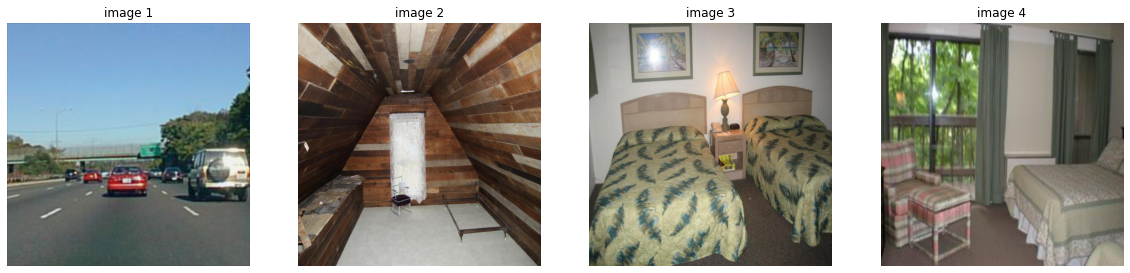

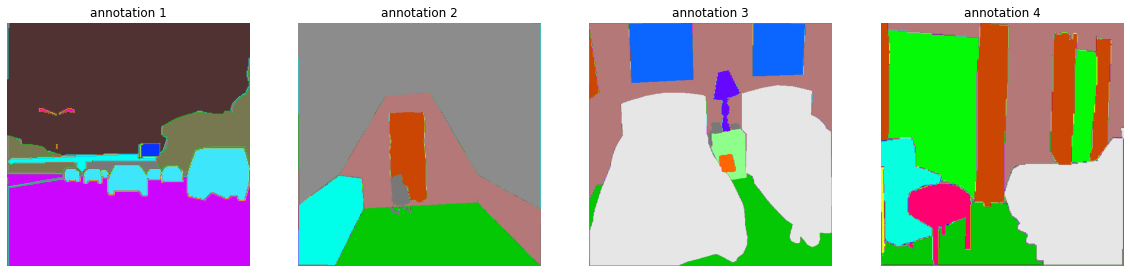

In [12]:
visualize_first_n(img, seg, 4)

## Define our Loss Function
weighted average of segmentation loss and edge classification loss.

In [8]:
class SegLossAttention(nn.Module):
    def __init__(self, num_classes, mode='train'):
        super(SegLossAttention, self).__init__()
        w = np.ones(shape=151)
        self.num_classes = num_classes
        self.seg_loss = torch.nn.CrossEntropyLoss() # softmax with crossentropy


    def forward(self, inputs, targets):

        loss = self.seg_loss(inputs, targets.long())

        return loss

## Training

In [9]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [11]:
def train(train_loader, net, edge_net, criterion, optimizer, curr_epoch):
    """
    Runs the training loop per epoch
    train_loader: Data loader for train
    net: the network
    optimizer: optimizer
    curr_epoch: current epoch
    writer: tensorboard writer
    return:
    """
    net.train()
    edge_net.eval()
    #net = net.to(device)

    train_main_loss = AverageMeter()
    curr_iter = 0#curr_epoch * len(train_loader)

    batches = tqdm(train_loader, total=len(train_loader))
    batches.set_description('Training: [epoch {}], [iter {} / {}], [seg loss {:0.6f}],[edge_loss {:0.6f}],[lr {:0.6f}]')

    for inputs, mask in batches:

        inputs = inputs.type(torch.cuda.FloatTensor).to(device)
        mask = mask.type(torch.cuda.FloatTensor).to(device)

        with torch.no_grad():
          edge_out = edge_net(inputs)
          edge_out = edge_out.type(torch.cuda.FloatTensor).to(device)

        optimizer.zero_grad()

        seg_out = net.forward(inputs, edge_out)
        loss = criterion(seg_out, mask)
        train_main_loss.update(loss.item())

        loss.backward()
        optimizer.step()
        
        batches.set_description('Train: [epoch {}], [{} / {}], [seg loss {:0.2f}],[lr {:0.4f}]'.format(
              epoch, curr_iter + 1, len(train_loader), loss ,optimizer.param_groups[-1]['lr']))
        
        if curr_iter % 100 == 0:
          print('Train: [epoch {}], [{} / {}], [seg loss {:0.2f}],[lr {:0.4f}]'.format(
              epoch, curr_iter + 1, len(train_loader), loss ,optimizer.param_groups[-1]['lr']))
          
        curr_iter += 1

    return  train_main_loss.avg

In [12]:
def validate(val_loader, net, edge_net, criterion, curr_epoch):
    """
    Runs the validation loop after each training epoch
    val_loader: Data loader for validation
    net: thet network
    criterion: loss fn
    optimizer: optimizer
    curr_epoch: current epoch
    writer: tensorboard writer
    return: val_avg for step function if required
    """

    net.eval()
    edge_net.eval()
    val_loss = AverageMeter()
    iou_acc = 0
    curr_iter = curr_epoch * len(val_loader)

    batches = tqdm(val_loader, total=len(val_loader))
    batches.set_description('Training: [epoch {}], [iter {} / {}], [seg loss {:0.6f}],[edge_loss {:0.6f}],[lr {:0.6f}]')

    for inputs, mask in batches:

        inputs = inputs.type(torch.cuda.FloatTensor).to(device)
        mask = mask.type(torch.cuda.FloatTensor).to(device)
        edge_out = edge_net(inputs)
        edge_out = edge_out.type(torch.cuda.FloatTensor).to(device)

        with torch.no_grad():
            seg_out = net(inputs, edge_out)

        loss = criterion(seg_out, mask)

        val_loss.update(loss.item())
        curr_iter += 1
        

        batches.set_description('Val: [epoch {}], [{} / {}], [seg loss {:0.2f}]'.format(
              epoch, curr_iter + 1, len(val_loader), loss))
          

    return val_loss.avg # retuen the value of loss

In [13]:
batch_size = 4
num_classes = 151
learning_rate = 0.001
load_weight = False
start_epoch = 0
max_epoch = 30
weight_decay = 5e-4
momentum = 0.9
model_name = "unet_pretrained_edge"
save_dir = f"/content/drive/MyDrive/MIT/6.869/Project/model/{model_name}"

if not os.path.exists(save_dir):
  os.makedirs(save_dir)
  print("Directory '%s' created" %model_name)

In [14]:
folder_path = "/content/data/datasets/ADEChallengeData2016/"

In [28]:
train_data = DataLoaderSegmentation(folder_path)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16)
print("Check how many steps in one training epoch: ", len(train_data_loader))
validation_data = DataLoaderSegmentation(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=16)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  632
Check how many steps in one training epoch:  63


In [ ]:
execfile("/content/Unet_with_pretrained_edge.py")
net = UnetResNetEdge(encoder_name="resnet34",
                           num_classes=151, 
                           input_channels=3, 
                           num_filters=32, 
                           Dropout=0.3)
net.to(device)

In [ ]:
execfile("/content/Edgenet.py")
edge_net = EdgeNet(encoder_name="resnet34",
                           num_classes=151, 
                           input_channels=3, 
                           num_filters=32, 
                           Dropout=0.3)
edge_net.to(device)

In [17]:
weight_file = f"{save_dir}/unet_edge_model_e28.pth"

net.load_state_dict(torch.load(weight_file))
net.to(device)
print(f"Load weight from {weight_file}")

Load weight from /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e28.pth


In [19]:
pretrain_edge_weight_file = "/content/unet_edge_model_edge.pth"
edge_net.load_state_dict(torch.load(pretrain_edge_weight_file))
edge_net.to(device)
print(f"Load weight from {pretrain_edge_weight_file}")

Load weight from /content/unet_edge_model_edge.pth


In [16]:
criterion = SegLossAttention(num_classes, mode='train').to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lambda1 = lambda epoch: math.pow(1 - epoch / max_epoch, 0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

train_loss = []
val_loss = []

best_loss = 1000

In [17]:
for epoch in range(start_epoch, max_epoch):
    
    train_l = train(train_data_loader, net, edge_net, criterion, optimizer, epoch)
    print('Train: [epoch {}], [Avg loss {:0.2f}]'.format(epoch, train_l))
    val_l = validate(validation_data_loader, net, edge_net, criterion, epoch)
    print('Val: [epoch {}], [Avg loss {:0.2f}]'.format(epoch, val_l))
    train_loss.append(train_l)
    val_loss.append(val_l)

    if val_l < best_loss:
      model_name = f"{save_dir}/unet_edge_model_e{epoch}.pth"
      torch.save(net.state_dict(), model_name)
      print(f"Save {model_name}!")
      best_loss = val_l

    scheduler.step()

    with open(f"{save_dir}/loss_record.txt", "w") as f:
      f.write("train_loss:" + "\n")
      for s in train_loss:
        f.write(str(s) +" ")
      
      # f.write("train_seg_loss:" + "\n")
      # for s in train_seg_loss:
      #   f.write(str(s) +" ")
      
      # f.write("train_edge_loss:" + "\n")
      # for s in train_edge_loss:
      #   f.write(str(s) +" ")
      
      f.write("val_loss:" + "\n")
      for s in val_loss:
        f.write(str(s) +" ")

  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 0], [1 / 2526], [seg loss 5.02],[lr 0.0010]
Train: [epoch 0], [101 / 2526], [seg loss 3.59],[lr 0.0010]
Train: [epoch 0], [201 / 2526], [seg loss 3.67],[lr 0.0010]
Train: [epoch 0], [301 / 2526], [seg loss 3.26],[lr 0.0010]
Train: [epoch 0], [401 / 2526], [seg loss 3.10],[lr 0.0010]
Train: [epoch 0], [501 / 2526], [seg loss 2.78],[lr 0.0010]
Train: [epoch 0], [601 / 2526], [seg loss 2.63],[lr 0.0010]
Train: [epoch 0], [701 / 2526], [seg loss 3.51],[lr 0.0010]
Train: [epoch 0], [801 / 2526], [seg loss 2.97],[lr 0.0010]
Train: [epoch 0], [901 / 2526], [seg loss 3.11],[lr 0.0010]
Train: [epoch 0], [1001 / 2526], [seg loss 3.02],[lr 0.0010]
Train: [epoch 0], [1101 / 2526], [seg loss 3.02],[lr 0.0010]
Train: [epoch 0], [1201 / 2526], [seg loss 3.08],[lr 0.0010]
Train: [epoch 0], [1301 / 2526], [seg loss 2.42],[lr 0.0010]
Train: [epoch 0], [1401 / 2526], [seg loss 2.83],[lr 0.0010]
Train: [epoch 0], [1501 / 2526], [seg loss 2.86],[lr 0.0010]
Train: [epoch 0], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 0], [Avg loss 2.84]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e0.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 1], [1 / 2526], [seg loss 2.54],[lr 0.0010]
Train: [epoch 1], [101 / 2526], [seg loss 3.70],[lr 0.0010]
Train: [epoch 1], [201 / 2526], [seg loss 3.13],[lr 0.0010]
Train: [epoch 1], [301 / 2526], [seg loss 2.63],[lr 0.0010]
Train: [epoch 1], [401 / 2526], [seg loss 2.61],[lr 0.0010]
Train: [epoch 1], [501 / 2526], [seg loss 2.13],[lr 0.0010]
Train: [epoch 1], [601 / 2526], [seg loss 2.58],[lr 0.0010]
Train: [epoch 1], [701 / 2526], [seg loss 2.55],[lr 0.0010]
Train: [epoch 1], [801 / 2526], [seg loss 2.62],[lr 0.0010]
Train: [epoch 1], [901 / 2526], [seg loss 2.91],[lr 0.0010]
Train: [epoch 1], [1001 / 2526], [seg loss 2.72],[lr 0.0010]
Train: [epoch 1], [1101 / 2526], [seg loss 2.72],[lr 0.0010]
Train: [epoch 1], [1201 / 2526], [seg loss 3.21],[lr 0.0010]
Train: [epoch 1], [1301 / 2526], [seg loss 2.63],[lr 0.0010]
Train: [epoch 1], [1401 / 2526], [seg loss 3.17],[lr 0.0010]
Train: [epoch 1], [1501 / 2526], [seg loss 3.51],[lr 0.0010]
Train: [epoch 1], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 1], [Avg loss 2.62]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e1.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 2], [1 / 2526], [seg loss 3.30],[lr 0.0009]
Train: [epoch 2], [101 / 2526], [seg loss 2.79],[lr 0.0009]
Train: [epoch 2], [201 / 2526], [seg loss 2.83],[lr 0.0009]
Train: [epoch 2], [301 / 2526], [seg loss 3.21],[lr 0.0009]
Train: [epoch 2], [401 / 2526], [seg loss 2.18],[lr 0.0009]
Train: [epoch 2], [501 / 2526], [seg loss 2.14],[lr 0.0009]
Train: [epoch 2], [601 / 2526], [seg loss 2.20],[lr 0.0009]
Train: [epoch 2], [701 / 2526], [seg loss 2.35],[lr 0.0009]
Train: [epoch 2], [801 / 2526], [seg loss 2.12],[lr 0.0009]
Train: [epoch 2], [901 / 2526], [seg loss 2.07],[lr 0.0009]
Train: [epoch 2], [1001 / 2526], [seg loss 2.20],[lr 0.0009]
Train: [epoch 2], [1101 / 2526], [seg loss 2.84],[lr 0.0009]
Train: [epoch 2], [1201 / 2526], [seg loss 2.74],[lr 0.0009]
Train: [epoch 2], [1301 / 2526], [seg loss 2.62],[lr 0.0009]
Train: [epoch 2], [1401 / 2526], [seg loss 2.22],[lr 0.0009]
Train: [epoch 2], [1501 / 2526], [seg loss 2.52],[lr 0.0009]
Train: [epoch 2], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 2], [Avg loss 2.48]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e2.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 3], [1 / 2526], [seg loss 2.24],[lr 0.0009]
Train: [epoch 3], [101 / 2526], [seg loss 1.87],[lr 0.0009]
Train: [epoch 3], [201 / 2526], [seg loss 2.71],[lr 0.0009]
Train: [epoch 3], [301 / 2526], [seg loss 2.61],[lr 0.0009]
Train: [epoch 3], [401 / 2526], [seg loss 2.17],[lr 0.0009]
Train: [epoch 3], [501 / 2526], [seg loss 2.83],[lr 0.0009]
Train: [epoch 3], [601 / 2526], [seg loss 2.24],[lr 0.0009]
Train: [epoch 3], [701 / 2526], [seg loss 2.57],[lr 0.0009]
Train: [epoch 3], [801 / 2526], [seg loss 2.55],[lr 0.0009]
Train: [epoch 3], [901 / 2526], [seg loss 2.17],[lr 0.0009]
Train: [epoch 3], [1001 / 2526], [seg loss 3.01],[lr 0.0009]
Train: [epoch 3], [1101 / 2526], [seg loss 1.87],[lr 0.0009]
Train: [epoch 3], [1201 / 2526], [seg loss 2.78],[lr 0.0009]
Train: [epoch 3], [1301 / 2526], [seg loss 2.23],[lr 0.0009]
Train: [epoch 3], [1401 / 2526], [seg loss 2.00],[lr 0.0009]
Train: [epoch 3], [1501 / 2526], [seg loss 1.72],[lr 0.0009]
Train: [epoch 3], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 3], [Avg loss 2.32]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e3.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 4], [1 / 2526], [seg loss 2.27],[lr 0.0009]
Train: [epoch 4], [101 / 2526], [seg loss 1.97],[lr 0.0009]
Train: [epoch 4], [201 / 2526], [seg loss 2.57],[lr 0.0009]
Train: [epoch 4], [301 / 2526], [seg loss 3.38],[lr 0.0009]
Train: [epoch 4], [401 / 2526], [seg loss 2.36],[lr 0.0009]
Train: [epoch 4], [501 / 2526], [seg loss 2.69],[lr 0.0009]
Train: [epoch 4], [601 / 2526], [seg loss 2.83],[lr 0.0009]
Train: [epoch 4], [701 / 2526], [seg loss 2.47],[lr 0.0009]
Train: [epoch 4], [801 / 2526], [seg loss 1.87],[lr 0.0009]
Train: [epoch 4], [901 / 2526], [seg loss 2.17],[lr 0.0009]
Train: [epoch 4], [1001 / 2526], [seg loss 2.06],[lr 0.0009]
Train: [epoch 4], [1101 / 2526], [seg loss 2.99],[lr 0.0009]
Train: [epoch 4], [1201 / 2526], [seg loss 3.04],[lr 0.0009]
Train: [epoch 4], [1301 / 2526], [seg loss 2.01],[lr 0.0009]
Train: [epoch 4], [1401 / 2526], [seg loss 1.29],[lr 0.0009]
Train: [epoch 4], [1501 / 2526], [seg loss 1.66],[lr 0.0009]
Train: [epoch 4], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 4], [Avg loss 2.36]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 5], [1 / 2526], [seg loss 1.80],[lr 0.0008]
Train: [epoch 5], [101 / 2526], [seg loss 2.05],[lr 0.0008]
Train: [epoch 5], [201 / 2526], [seg loss 2.14],[lr 0.0008]
Train: [epoch 5], [301 / 2526], [seg loss 1.95],[lr 0.0008]
Train: [epoch 5], [401 / 2526], [seg loss 2.14],[lr 0.0008]
Train: [epoch 5], [501 / 2526], [seg loss 1.85],[lr 0.0008]
Train: [epoch 5], [601 / 2526], [seg loss 2.25],[lr 0.0008]
Train: [epoch 5], [701 / 2526], [seg loss 2.42],[lr 0.0008]
Train: [epoch 5], [801 / 2526], [seg loss 2.19],[lr 0.0008]
Train: [epoch 5], [901 / 2526], [seg loss 2.87],[lr 0.0008]
Train: [epoch 5], [1001 / 2526], [seg loss 1.67],[lr 0.0008]
Train: [epoch 5], [1101 / 2526], [seg loss 1.85],[lr 0.0008]
Train: [epoch 5], [1201 / 2526], [seg loss 1.79],[lr 0.0008]
Train: [epoch 5], [1301 / 2526], [seg loss 2.09],[lr 0.0008]
Train: [epoch 5], [1401 / 2526], [seg loss 1.73],[lr 0.0008]
Train: [epoch 5], [1501 / 2526], [seg loss 2.32],[lr 0.0008]
Train: [epoch 5], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 5], [Avg loss 2.25]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e5.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 6], [1 / 2526], [seg loss 2.21],[lr 0.0008]
Train: [epoch 6], [101 / 2526], [seg loss 2.01],[lr 0.0008]
Train: [epoch 6], [201 / 2526], [seg loss 1.95],[lr 0.0008]
Train: [epoch 6], [301 / 2526], [seg loss 1.91],[lr 0.0008]
Train: [epoch 6], [401 / 2526], [seg loss 2.19],[lr 0.0008]
Train: [epoch 6], [501 / 2526], [seg loss 2.16],[lr 0.0008]
Train: [epoch 6], [601 / 2526], [seg loss 2.25],[lr 0.0008]
Train: [epoch 6], [701 / 2526], [seg loss 1.72],[lr 0.0008]
Train: [epoch 6], [801 / 2526], [seg loss 2.76],[lr 0.0008]
Train: [epoch 6], [901 / 2526], [seg loss 2.26],[lr 0.0008]
Train: [epoch 6], [1001 / 2526], [seg loss 1.48],[lr 0.0008]
Train: [epoch 6], [1101 / 2526], [seg loss 2.00],[lr 0.0008]
Train: [epoch 6], [1201 / 2526], [seg loss 2.25],[lr 0.0008]
Train: [epoch 6], [1301 / 2526], [seg loss 1.84],[lr 0.0008]
Train: [epoch 6], [1401 / 2526], [seg loss 2.27],[lr 0.0008]
Train: [epoch 6], [1501 / 2526], [seg loss 2.93],[lr 0.0008]
Train: [epoch 6], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 6], [Avg loss 2.22]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e6.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 7], [1 / 2526], [seg loss 2.61],[lr 0.0008]
Train: [epoch 7], [101 / 2526], [seg loss 2.35],[lr 0.0008]
Train: [epoch 7], [201 / 2526], [seg loss 1.46],[lr 0.0008]
Train: [epoch 7], [301 / 2526], [seg loss 2.01],[lr 0.0008]
Train: [epoch 7], [401 / 2526], [seg loss 2.06],[lr 0.0008]
Train: [epoch 7], [501 / 2526], [seg loss 1.35],[lr 0.0008]
Train: [epoch 7], [601 / 2526], [seg loss 2.29],[lr 0.0008]
Train: [epoch 7], [701 / 2526], [seg loss 1.99],[lr 0.0008]
Train: [epoch 7], [801 / 2526], [seg loss 2.96],[lr 0.0008]
Train: [epoch 7], [901 / 2526], [seg loss 2.48],[lr 0.0008]
Train: [epoch 7], [1001 / 2526], [seg loss 1.76],[lr 0.0008]
Train: [epoch 7], [1101 / 2526], [seg loss 2.26],[lr 0.0008]
Train: [epoch 7], [1201 / 2526], [seg loss 2.07],[lr 0.0008]
Train: [epoch 7], [1301 / 2526], [seg loss 2.05],[lr 0.0008]
Train: [epoch 7], [1401 / 2526], [seg loss 2.31],[lr 0.0008]
Train: [epoch 7], [1501 / 2526], [seg loss 2.42],[lr 0.0008]
Train: [epoch 7], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 7], [Avg loss 2.13]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e7.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 8], [1 / 2526], [seg loss 2.15],[lr 0.0008]
Train: [epoch 8], [101 / 2526], [seg loss 2.05],[lr 0.0008]
Train: [epoch 8], [201 / 2526], [seg loss 2.26],[lr 0.0008]
Train: [epoch 8], [301 / 2526], [seg loss 1.37],[lr 0.0008]
Train: [epoch 8], [401 / 2526], [seg loss 2.58],[lr 0.0008]
Train: [epoch 8], [501 / 2526], [seg loss 2.12],[lr 0.0008]
Train: [epoch 8], [601 / 2526], [seg loss 1.12],[lr 0.0008]
Train: [epoch 8], [701 / 2526], [seg loss 2.38],[lr 0.0008]
Train: [epoch 8], [801 / 2526], [seg loss 1.63],[lr 0.0008]
Train: [epoch 8], [901 / 2526], [seg loss 2.13],[lr 0.0008]
Train: [epoch 8], [1001 / 2526], [seg loss 1.58],[lr 0.0008]
Train: [epoch 8], [1101 / 2526], [seg loss 2.31],[lr 0.0008]
Train: [epoch 8], [1201 / 2526], [seg loss 2.47],[lr 0.0008]
Train: [epoch 8], [1301 / 2526], [seg loss 2.26],[lr 0.0008]
Train: [epoch 8], [1401 / 2526], [seg loss 1.54],[lr 0.0008]
Train: [epoch 8], [1501 / 2526], [seg loss 1.94],[lr 0.0008]
Train: [epoch 8], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 8], [Avg loss 2.12]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e8.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 9], [1 / 2526], [seg loss 2.30],[lr 0.0007]
Train: [epoch 9], [101 / 2526], [seg loss 2.69],[lr 0.0007]
Train: [epoch 9], [201 / 2526], [seg loss 2.85],[lr 0.0007]
Train: [epoch 9], [301 / 2526], [seg loss 2.15],[lr 0.0007]
Train: [epoch 9], [401 / 2526], [seg loss 2.19],[lr 0.0007]
Train: [epoch 9], [501 / 2526], [seg loss 2.16],[lr 0.0007]
Train: [epoch 9], [601 / 2526], [seg loss 3.16],[lr 0.0007]
Train: [epoch 9], [701 / 2526], [seg loss 2.03],[lr 0.0007]
Train: [epoch 9], [801 / 2526], [seg loss 1.99],[lr 0.0007]
Train: [epoch 9], [901 / 2526], [seg loss 1.92],[lr 0.0007]
Train: [epoch 9], [1001 / 2526], [seg loss 1.16],[lr 0.0007]
Train: [epoch 9], [1101 / 2526], [seg loss 1.73],[lr 0.0007]
Train: [epoch 9], [1201 / 2526], [seg loss 1.69],[lr 0.0007]
Train: [epoch 9], [1301 / 2526], [seg loss 2.54],[lr 0.0007]
Train: [epoch 9], [1401 / 2526], [seg loss 2.56],[lr 0.0007]
Train: [epoch 9], [1501 / 2526], [seg loss 2.38],[lr 0.0007]
Train: [epoch 9], [1601 / 2526], [se

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 9], [Avg loss 2.06]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e9.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 10], [1 / 2526], [seg loss 1.61],[lr 0.0007]
Train: [epoch 10], [101 / 2526], [seg loss 1.33],[lr 0.0007]
Train: [epoch 10], [201 / 2526], [seg loss 2.06],[lr 0.0007]
Train: [epoch 10], [301 / 2526], [seg loss 1.54],[lr 0.0007]
Train: [epoch 10], [401 / 2526], [seg loss 1.66],[lr 0.0007]
Train: [epoch 10], [501 / 2526], [seg loss 2.17],[lr 0.0007]
Train: [epoch 10], [601 / 2526], [seg loss 1.78],[lr 0.0007]
Train: [epoch 10], [701 / 2526], [seg loss 2.54],[lr 0.0007]
Train: [epoch 10], [801 / 2526], [seg loss 2.37],[lr 0.0007]
Train: [epoch 10], [901 / 2526], [seg loss 2.16],[lr 0.0007]
Train: [epoch 10], [1001 / 2526], [seg loss 1.89],[lr 0.0007]
Train: [epoch 10], [1101 / 2526], [seg loss 2.35],[lr 0.0007]
Train: [epoch 10], [1201 / 2526], [seg loss 2.41],[lr 0.0007]
Train: [epoch 10], [1301 / 2526], [seg loss 2.23],[lr 0.0007]
Train: [epoch 10], [1401 / 2526], [seg loss 2.24],[lr 0.0007]
Train: [epoch 10], [1501 / 2526], [seg loss 1.83],[lr 0.0007]
Train: [epoch 10], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 10], [Avg loss 2.03]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e10.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 11], [1 / 2526], [seg loss 2.13],[lr 0.0007]
Train: [epoch 11], [101 / 2526], [seg loss 3.01],[lr 0.0007]
Train: [epoch 11], [201 / 2526], [seg loss 1.82],[lr 0.0007]
Train: [epoch 11], [301 / 2526], [seg loss 1.66],[lr 0.0007]
Train: [epoch 11], [401 / 2526], [seg loss 2.62],[lr 0.0007]
Train: [epoch 11], [501 / 2526], [seg loss 3.06],[lr 0.0007]
Train: [epoch 11], [601 / 2526], [seg loss 1.68],[lr 0.0007]
Train: [epoch 11], [701 / 2526], [seg loss 1.61],[lr 0.0007]
Train: [epoch 11], [801 / 2526], [seg loss 2.37],[lr 0.0007]
Train: [epoch 11], [901 / 2526], [seg loss 2.33],[lr 0.0007]
Train: [epoch 11], [1001 / 2526], [seg loss 2.22],[lr 0.0007]
Train: [epoch 11], [1101 / 2526], [seg loss 1.82],[lr 0.0007]
Train: [epoch 11], [1201 / 2526], [seg loss 1.75],[lr 0.0007]
Train: [epoch 11], [1301 / 2526], [seg loss 2.19],[lr 0.0007]
Train: [epoch 11], [1401 / 2526], [seg loss 2.72],[lr 0.0007]
Train: [epoch 11], [1501 / 2526], [seg loss 1.76],[lr 0.0007]
Train: [epoch 11], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 11], [Avg loss 2.01]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e11.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 12], [1 / 2526], [seg loss 1.98],[lr 0.0006]
Train: [epoch 12], [101 / 2526], [seg loss 1.38],[lr 0.0006]
Train: [epoch 12], [201 / 2526], [seg loss 1.63],[lr 0.0006]
Train: [epoch 12], [301 / 2526], [seg loss 1.21],[lr 0.0006]
Train: [epoch 12], [401 / 2526], [seg loss 2.22],[lr 0.0006]
Train: [epoch 12], [501 / 2526], [seg loss 1.26],[lr 0.0006]
Train: [epoch 12], [601 / 2526], [seg loss 1.84],[lr 0.0006]
Train: [epoch 12], [701 / 2526], [seg loss 1.90],[lr 0.0006]
Train: [epoch 12], [801 / 2526], [seg loss 2.03],[lr 0.0006]
Train: [epoch 12], [901 / 2526], [seg loss 1.88],[lr 0.0006]
Train: [epoch 12], [1001 / 2526], [seg loss 1.89],[lr 0.0006]
Train: [epoch 12], [1101 / 2526], [seg loss 1.73],[lr 0.0006]
Train: [epoch 12], [1201 / 2526], [seg loss 1.68],[lr 0.0006]
Train: [epoch 12], [1301 / 2526], [seg loss 1.67],[lr 0.0006]
Train: [epoch 12], [1401 / 2526], [seg loss 1.69],[lr 0.0006]
Train: [epoch 12], [1501 / 2526], [seg loss 1.62],[lr 0.0006]
Train: [epoch 12], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 12], [Avg loss 2.07]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 13], [1 / 2526], [seg loss 1.37],[lr 0.0006]
Train: [epoch 13], [101 / 2526], [seg loss 1.87],[lr 0.0006]
Train: [epoch 13], [201 / 2526], [seg loss 1.04],[lr 0.0006]
Train: [epoch 13], [301 / 2526], [seg loss 2.51],[lr 0.0006]
Train: [epoch 13], [401 / 2526], [seg loss 1.64],[lr 0.0006]
Train: [epoch 13], [501 / 2526], [seg loss 1.88],[lr 0.0006]
Train: [epoch 13], [601 / 2526], [seg loss 1.53],[lr 0.0006]
Train: [epoch 13], [701 / 2526], [seg loss 2.18],[lr 0.0006]
Train: [epoch 13], [801 / 2526], [seg loss 1.79],[lr 0.0006]
Train: [epoch 13], [901 / 2526], [seg loss 2.33],[lr 0.0006]
Train: [epoch 13], [1001 / 2526], [seg loss 1.55],[lr 0.0006]
Train: [epoch 13], [1101 / 2526], [seg loss 1.84],[lr 0.0006]
Train: [epoch 13], [1201 / 2526], [seg loss 2.51],[lr 0.0006]
Train: [epoch 13], [1301 / 2526], [seg loss 1.43],[lr 0.0006]
Train: [epoch 13], [1401 / 2526], [seg loss 2.21],[lr 0.0006]
Train: [epoch 13], [1501 / 2526], [seg loss 1.15],[lr 0.0006]
Train: [epoch 13], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 13], [Avg loss 2.00]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e13.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 14], [1 / 2526], [seg loss 1.36],[lr 0.0006]
Train: [epoch 14], [101 / 2526], [seg loss 1.55],[lr 0.0006]
Train: [epoch 14], [201 / 2526], [seg loss 1.83],[lr 0.0006]
Train: [epoch 14], [301 / 2526], [seg loss 1.90],[lr 0.0006]
Train: [epoch 14], [401 / 2526], [seg loss 1.94],[lr 0.0006]
Train: [epoch 14], [501 / 2526], [seg loss 2.05],[lr 0.0006]
Train: [epoch 14], [601 / 2526], [seg loss 1.54],[lr 0.0006]
Train: [epoch 14], [701 / 2526], [seg loss 1.70],[lr 0.0006]
Train: [epoch 14], [801 / 2526], [seg loss 1.34],[lr 0.0006]
Train: [epoch 14], [901 / 2526], [seg loss 2.17],[lr 0.0006]
Train: [epoch 14], [1001 / 2526], [seg loss 1.56],[lr 0.0006]
Train: [epoch 14], [1101 / 2526], [seg loss 1.38],[lr 0.0006]
Train: [epoch 14], [1201 / 2526], [seg loss 1.68],[lr 0.0006]
Train: [epoch 14], [1301 / 2526], [seg loss 1.54],[lr 0.0006]
Train: [epoch 14], [1401 / 2526], [seg loss 1.42],[lr 0.0006]
Train: [epoch 14], [1501 / 2526], [seg loss 2.33],[lr 0.0006]
Train: [epoch 14], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 14], [Avg loss 2.02]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 15], [1 / 2526], [seg loss 1.72],[lr 0.0005]
Train: [epoch 15], [101 / 2526], [seg loss 2.43],[lr 0.0005]
Train: [epoch 15], [201 / 2526], [seg loss 1.70],[lr 0.0005]
Train: [epoch 15], [301 / 2526], [seg loss 2.00],[lr 0.0005]
Train: [epoch 15], [401 / 2526], [seg loss 2.22],[lr 0.0005]
Train: [epoch 15], [501 / 2526], [seg loss 1.43],[lr 0.0005]
Train: [epoch 15], [601 / 2526], [seg loss 2.04],[lr 0.0005]
Train: [epoch 15], [701 / 2526], [seg loss 2.10],[lr 0.0005]
Train: [epoch 15], [801 / 2526], [seg loss 1.56],[lr 0.0005]
Train: [epoch 15], [901 / 2526], [seg loss 1.28],[lr 0.0005]
Train: [epoch 15], [1001 / 2526], [seg loss 2.72],[lr 0.0005]
Train: [epoch 15], [1101 / 2526], [seg loss 1.19],[lr 0.0005]
Train: [epoch 15], [1201 / 2526], [seg loss 1.41],[lr 0.0005]
Train: [epoch 15], [1301 / 2526], [seg loss 1.65],[lr 0.0005]
Train: [epoch 15], [1401 / 2526], [seg loss 1.78],[lr 0.0005]
Train: [epoch 15], [1501 / 2526], [seg loss 1.61],[lr 0.0005]
Train: [epoch 15], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 15], [Avg loss 1.94]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e15.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 16], [1 / 2526], [seg loss 1.34],[lr 0.0005]
Train: [epoch 16], [101 / 2526], [seg loss 2.19],[lr 0.0005]
Train: [epoch 16], [201 / 2526], [seg loss 2.05],[lr 0.0005]
Train: [epoch 16], [301 / 2526], [seg loss 1.14],[lr 0.0005]
Train: [epoch 16], [401 / 2526], [seg loss 1.30],[lr 0.0005]
Train: [epoch 16], [501 / 2526], [seg loss 1.87],[lr 0.0005]
Train: [epoch 16], [601 / 2526], [seg loss 1.68],[lr 0.0005]
Train: [epoch 16], [701 / 2526], [seg loss 1.48],[lr 0.0005]
Train: [epoch 16], [801 / 2526], [seg loss 2.24],[lr 0.0005]
Train: [epoch 16], [901 / 2526], [seg loss 1.71],[lr 0.0005]
Train: [epoch 16], [1001 / 2526], [seg loss 2.07],[lr 0.0005]
Train: [epoch 16], [1101 / 2526], [seg loss 1.68],[lr 0.0005]
Train: [epoch 16], [1201 / 2526], [seg loss 1.68],[lr 0.0005]
Train: [epoch 16], [1301 / 2526], [seg loss 1.84],[lr 0.0005]
Train: [epoch 16], [1401 / 2526], [seg loss 0.98],[lr 0.0005]
Train: [epoch 16], [1501 / 2526], [seg loss 1.17],[lr 0.0005]
Train: [epoch 16], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 16], [Avg loss 1.90]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e16.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 17], [1 / 2526], [seg loss 1.84],[lr 0.0005]
Train: [epoch 17], [101 / 2526], [seg loss 1.69],[lr 0.0005]
Train: [epoch 17], [201 / 2526], [seg loss 1.34],[lr 0.0005]
Train: [epoch 17], [301 / 2526], [seg loss 1.49],[lr 0.0005]
Train: [epoch 17], [401 / 2526], [seg loss 1.62],[lr 0.0005]
Train: [epoch 17], [501 / 2526], [seg loss 2.19],[lr 0.0005]
Train: [epoch 17], [601 / 2526], [seg loss 1.88],[lr 0.0005]
Train: [epoch 17], [701 / 2526], [seg loss 1.05],[lr 0.0005]
Train: [epoch 17], [801 / 2526], [seg loss 1.73],[lr 0.0005]
Train: [epoch 17], [901 / 2526], [seg loss 1.93],[lr 0.0005]
Train: [epoch 17], [1001 / 2526], [seg loss 2.09],[lr 0.0005]
Train: [epoch 17], [1101 / 2526], [seg loss 2.58],[lr 0.0005]
Train: [epoch 17], [1201 / 2526], [seg loss 1.59],[lr 0.0005]
Train: [epoch 17], [1301 / 2526], [seg loss 1.68],[lr 0.0005]
Train: [epoch 17], [1401 / 2526], [seg loss 2.05],[lr 0.0005]
Train: [epoch 17], [1501 / 2526], [seg loss 1.69],[lr 0.0005]
Train: [epoch 17], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 17], [Avg loss 1.87]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e17.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 18], [1 / 2526], [seg loss 1.18],[lr 0.0004]
Train: [epoch 18], [101 / 2526], [seg loss 2.07],[lr 0.0004]
Train: [epoch 18], [201 / 2526], [seg loss 1.50],[lr 0.0004]
Train: [epoch 18], [301 / 2526], [seg loss 2.51],[lr 0.0004]
Train: [epoch 18], [401 / 2526], [seg loss 1.64],[lr 0.0004]
Train: [epoch 18], [501 / 2526], [seg loss 1.76],[lr 0.0004]
Train: [epoch 18], [601 / 2526], [seg loss 1.83],[lr 0.0004]
Train: [epoch 18], [701 / 2526], [seg loss 1.83],[lr 0.0004]
Train: [epoch 18], [801 / 2526], [seg loss 1.57],[lr 0.0004]
Train: [epoch 18], [901 / 2526], [seg loss 1.70],[lr 0.0004]
Train: [epoch 18], [1001 / 2526], [seg loss 1.17],[lr 0.0004]
Train: [epoch 18], [1101 / 2526], [seg loss 1.58],[lr 0.0004]
Train: [epoch 18], [1201 / 2526], [seg loss 2.67],[lr 0.0004]
Train: [epoch 18], [1301 / 2526], [seg loss 2.08],[lr 0.0004]
Train: [epoch 18], [1401 / 2526], [seg loss 2.39],[lr 0.0004]
Train: [epoch 18], [1501 / 2526], [seg loss 2.49],[lr 0.0004]
Train: [epoch 18], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 18], [Avg loss 1.88]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 19], [1 / 2526], [seg loss 1.62],[lr 0.0004]
Train: [epoch 19], [101 / 2526], [seg loss 1.14],[lr 0.0004]
Train: [epoch 19], [201 / 2526], [seg loss 1.48],[lr 0.0004]
Train: [epoch 19], [301 / 2526], [seg loss 2.95],[lr 0.0004]
Train: [epoch 19], [401 / 2526], [seg loss 1.83],[lr 0.0004]
Train: [epoch 19], [501 / 2526], [seg loss 1.62],[lr 0.0004]
Train: [epoch 19], [601 / 2526], [seg loss 1.95],[lr 0.0004]
Train: [epoch 19], [701 / 2526], [seg loss 1.67],[lr 0.0004]
Train: [epoch 19], [801 / 2526], [seg loss 1.65],[lr 0.0004]
Train: [epoch 19], [901 / 2526], [seg loss 1.67],[lr 0.0004]
Train: [epoch 19], [1001 / 2526], [seg loss 1.97],[lr 0.0004]
Train: [epoch 19], [1101 / 2526], [seg loss 1.60],[lr 0.0004]
Train: [epoch 19], [1201 / 2526], [seg loss 1.84],[lr 0.0004]
Train: [epoch 19], [1301 / 2526], [seg loss 1.50],[lr 0.0004]
Train: [epoch 19], [1401 / 2526], [seg loss 0.88],[lr 0.0004]
Train: [epoch 19], [1501 / 2526], [seg loss 2.02],[lr 0.0004]
Train: [epoch 19], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 19], [Avg loss 1.88]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 20], [1 / 2526], [seg loss 2.31],[lr 0.0004]
Train: [epoch 20], [101 / 2526], [seg loss 1.58],[lr 0.0004]
Train: [epoch 20], [201 / 2526], [seg loss 2.37],[lr 0.0004]
Train: [epoch 20], [301 / 2526], [seg loss 1.81],[lr 0.0004]
Train: [epoch 20], [401 / 2526], [seg loss 2.33],[lr 0.0004]
Train: [epoch 20], [501 / 2526], [seg loss 2.14],[lr 0.0004]
Train: [epoch 20], [601 / 2526], [seg loss 2.30],[lr 0.0004]
Train: [epoch 20], [701 / 2526], [seg loss 2.00],[lr 0.0004]
Train: [epoch 20], [801 / 2526], [seg loss 0.94],[lr 0.0004]
Train: [epoch 20], [901 / 2526], [seg loss 1.57],[lr 0.0004]
Train: [epoch 20], [1001 / 2526], [seg loss 2.58],[lr 0.0004]
Train: [epoch 20], [1101 / 2526], [seg loss 1.75],[lr 0.0004]
Train: [epoch 20], [1201 / 2526], [seg loss 1.31],[lr 0.0004]
Train: [epoch 20], [1301 / 2526], [seg loss 1.49],[lr 0.0004]
Train: [epoch 20], [1401 / 2526], [seg loss 1.68],[lr 0.0004]
Train: [epoch 20], [1501 / 2526], [seg loss 1.92],[lr 0.0004]
Train: [epoch 20], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 20], [Avg loss 1.84]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e20.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 21], [1 / 2526], [seg loss 1.61],[lr 0.0003]
Train: [epoch 21], [101 / 2526], [seg loss 1.35],[lr 0.0003]
Train: [epoch 21], [201 / 2526], [seg loss 2.06],[lr 0.0003]
Train: [epoch 21], [301 / 2526], [seg loss 2.05],[lr 0.0003]
Train: [epoch 21], [401 / 2526], [seg loss 0.98],[lr 0.0003]
Train: [epoch 21], [501 / 2526], [seg loss 1.39],[lr 0.0003]
Train: [epoch 21], [601 / 2526], [seg loss 1.51],[lr 0.0003]
Train: [epoch 21], [701 / 2526], [seg loss 1.74],[lr 0.0003]
Train: [epoch 21], [801 / 2526], [seg loss 1.44],[lr 0.0003]
Train: [epoch 21], [901 / 2526], [seg loss 1.77],[lr 0.0003]
Train: [epoch 21], [1001 / 2526], [seg loss 2.01],[lr 0.0003]
Train: [epoch 21], [1101 / 2526], [seg loss 2.14],[lr 0.0003]
Train: [epoch 21], [1201 / 2526], [seg loss 2.27],[lr 0.0003]
Train: [epoch 21], [1301 / 2526], [seg loss 1.04],[lr 0.0003]
Train: [epoch 21], [1401 / 2526], [seg loss 1.69],[lr 0.0003]
Train: [epoch 21], [1501 / 2526], [seg loss 1.94],[lr 0.0003]
Train: [epoch 21], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 21], [Avg loss 1.86]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 22], [1 / 2526], [seg loss 1.58],[lr 0.0003]
Train: [epoch 22], [101 / 2526], [seg loss 1.48],[lr 0.0003]
Train: [epoch 22], [201 / 2526], [seg loss 1.71],[lr 0.0003]
Train: [epoch 22], [301 / 2526], [seg loss 1.42],[lr 0.0003]
Train: [epoch 22], [401 / 2526], [seg loss 1.69],[lr 0.0003]
Train: [epoch 22], [501 / 2526], [seg loss 2.15],[lr 0.0003]
Train: [epoch 22], [601 / 2526], [seg loss 1.70],[lr 0.0003]
Train: [epoch 22], [701 / 2526], [seg loss 2.08],[lr 0.0003]
Train: [epoch 22], [801 / 2526], [seg loss 2.25],[lr 0.0003]
Train: [epoch 22], [901 / 2526], [seg loss 1.55],[lr 0.0003]
Train: [epoch 22], [1001 / 2526], [seg loss 2.02],[lr 0.0003]
Train: [epoch 22], [1101 / 2526], [seg loss 1.78],[lr 0.0003]
Train: [epoch 22], [1201 / 2526], [seg loss 1.55],[lr 0.0003]
Train: [epoch 22], [1301 / 2526], [seg loss 1.79],[lr 0.0003]
Train: [epoch 22], [1401 / 2526], [seg loss 1.80],[lr 0.0003]
Train: [epoch 22], [1501 / 2526], [seg loss 1.32],[lr 0.0003]
Train: [epoch 22], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 22], [Avg loss 1.85]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 23], [1 / 2526], [seg loss 1.67],[lr 0.0003]
Train: [epoch 23], [101 / 2526], [seg loss 1.62],[lr 0.0003]
Train: [epoch 23], [201 / 2526], [seg loss 1.37],[lr 0.0003]
Train: [epoch 23], [301 / 2526], [seg loss 1.62],[lr 0.0003]
Train: [epoch 23], [401 / 2526], [seg loss 1.80],[lr 0.0003]
Train: [epoch 23], [501 / 2526], [seg loss 1.57],[lr 0.0003]
Train: [epoch 23], [601 / 2526], [seg loss 1.78],[lr 0.0003]
Train: [epoch 23], [701 / 2526], [seg loss 2.13],[lr 0.0003]
Train: [epoch 23], [801 / 2526], [seg loss 1.84],[lr 0.0003]
Train: [epoch 23], [901 / 2526], [seg loss 1.12],[lr 0.0003]
Train: [epoch 23], [1001 / 2526], [seg loss 0.88],[lr 0.0003]
Train: [epoch 23], [1101 / 2526], [seg loss 1.42],[lr 0.0003]
Train: [epoch 23], [1201 / 2526], [seg loss 2.93],[lr 0.0003]
Train: [epoch 23], [1301 / 2526], [seg loss 1.66],[lr 0.0003]
Train: [epoch 23], [1401 / 2526], [seg loss 2.73],[lr 0.0003]
Train: [epoch 23], [1501 / 2526], [seg loss 1.17],[lr 0.0003]
Train: [epoch 23], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 23], [Avg loss 1.86]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 24], [1 / 2526], [seg loss 2.14],[lr 0.0002]
Train: [epoch 24], [101 / 2526], [seg loss 1.33],[lr 0.0002]
Train: [epoch 24], [201 / 2526], [seg loss 1.32],[lr 0.0002]
Train: [epoch 24], [301 / 2526], [seg loss 1.59],[lr 0.0002]
Train: [epoch 24], [401 / 2526], [seg loss 2.00],[lr 0.0002]
Train: [epoch 24], [501 / 2526], [seg loss 1.42],[lr 0.0002]
Train: [epoch 24], [601 / 2526], [seg loss 1.58],[lr 0.0002]
Train: [epoch 24], [701 / 2526], [seg loss 1.26],[lr 0.0002]
Train: [epoch 24], [801 / 2526], [seg loss 2.01],[lr 0.0002]
Train: [epoch 24], [901 / 2526], [seg loss 1.55],[lr 0.0002]
Train: [epoch 24], [1001 / 2526], [seg loss 1.53],[lr 0.0002]
Train: [epoch 24], [1101 / 2526], [seg loss 2.26],[lr 0.0002]
Train: [epoch 24], [1201 / 2526], [seg loss 1.53],[lr 0.0002]
Train: [epoch 24], [1301 / 2526], [seg loss 1.48],[lr 0.0002]
Train: [epoch 24], [1401 / 2526], [seg loss 2.58],[lr 0.0002]
Train: [epoch 24], [1501 / 2526], [seg loss 1.33],[lr 0.0002]
Train: [epoch 24], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 24], [Avg loss 1.82]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e24.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 25], [1 / 2526], [seg loss 0.89],[lr 0.0002]
Train: [epoch 25], [101 / 2526], [seg loss 1.40],[lr 0.0002]
Train: [epoch 25], [201 / 2526], [seg loss 1.13],[lr 0.0002]
Train: [epoch 25], [301 / 2526], [seg loss 1.72],[lr 0.0002]
Train: [epoch 25], [401 / 2526], [seg loss 1.28],[lr 0.0002]
Train: [epoch 25], [501 / 2526], [seg loss 1.11],[lr 0.0002]
Train: [epoch 25], [601 / 2526], [seg loss 1.97],[lr 0.0002]
Train: [epoch 25], [701 / 2526], [seg loss 1.07],[lr 0.0002]
Train: [epoch 25], [801 / 2526], [seg loss 2.10],[lr 0.0002]
Train: [epoch 25], [901 / 2526], [seg loss 1.23],[lr 0.0002]
Train: [epoch 25], [1001 / 2526], [seg loss 1.07],[lr 0.0002]
Train: [epoch 25], [1101 / 2526], [seg loss 1.46],[lr 0.0002]
Train: [epoch 25], [1201 / 2526], [seg loss 2.05],[lr 0.0002]
Train: [epoch 25], [1301 / 2526], [seg loss 1.58],[lr 0.0002]
Train: [epoch 25], [1401 / 2526], [seg loss 1.42],[lr 0.0002]
Train: [epoch 25], [1501 / 2526], [seg loss 1.13],[lr 0.0002]
Train: [epoch 25], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 25], [Avg loss 1.87]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 26], [1 / 2526], [seg loss 1.60],[lr 0.0002]
Train: [epoch 26], [101 / 2526], [seg loss 2.16],[lr 0.0002]
Train: [epoch 26], [201 / 2526], [seg loss 2.01],[lr 0.0002]
Train: [epoch 26], [301 / 2526], [seg loss 1.37],[lr 0.0002]
Train: [epoch 26], [401 / 2526], [seg loss 1.13],[lr 0.0002]
Train: [epoch 26], [501 / 2526], [seg loss 1.11],[lr 0.0002]
Train: [epoch 26], [601 / 2526], [seg loss 1.42],[lr 0.0002]
Train: [epoch 26], [701 / 2526], [seg loss 1.94],[lr 0.0002]
Train: [epoch 26], [801 / 2526], [seg loss 1.30],[lr 0.0002]
Train: [epoch 26], [901 / 2526], [seg loss 1.61],[lr 0.0002]
Train: [epoch 26], [1001 / 2526], [seg loss 1.49],[lr 0.0002]
Train: [epoch 26], [1101 / 2526], [seg loss 1.99],[lr 0.0002]
Train: [epoch 26], [1201 / 2526], [seg loss 1.19],[lr 0.0002]
Train: [epoch 26], [1301 / 2526], [seg loss 1.61],[lr 0.0002]
Train: [epoch 26], [1401 / 2526], [seg loss 1.73],[lr 0.0002]
Train: [epoch 26], [1501 / 2526], [seg loss 1.47],[lr 0.0002]
Train: [epoch 26], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 26], [Avg loss 1.81]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e26.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 27], [1 / 2526], [seg loss 2.27],[lr 0.0001]
Train: [epoch 27], [101 / 2526], [seg loss 1.71],[lr 0.0001]
Train: [epoch 27], [201 / 2526], [seg loss 2.25],[lr 0.0001]
Train: [epoch 27], [301 / 2526], [seg loss 1.29],[lr 0.0001]
Train: [epoch 27], [401 / 2526], [seg loss 1.29],[lr 0.0001]
Train: [epoch 27], [501 / 2526], [seg loss 1.19],[lr 0.0001]
Train: [epoch 27], [601 / 2526], [seg loss 1.35],[lr 0.0001]
Train: [epoch 27], [701 / 2526], [seg loss 1.57],[lr 0.0001]
Train: [epoch 27], [801 / 2526], [seg loss 1.47],[lr 0.0001]
Train: [epoch 27], [901 / 2526], [seg loss 0.71],[lr 0.0001]
Train: [epoch 27], [1001 / 2526], [seg loss 1.67],[lr 0.0001]
Train: [epoch 27], [1101 / 2526], [seg loss 0.97],[lr 0.0001]
Train: [epoch 27], [1201 / 2526], [seg loss 1.80],[lr 0.0001]
Train: [epoch 27], [1301 / 2526], [seg loss 1.50],[lr 0.0001]
Train: [epoch 27], [1401 / 2526], [seg loss 1.33],[lr 0.0001]
Train: [epoch 27], [1501 / 2526], [seg loss 1.64],[lr 0.0001]
Train: [epoch 27], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 27], [Avg loss 1.80]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e27.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 28], [1 / 2526], [seg loss 1.90],[lr 0.0001]
Train: [epoch 28], [101 / 2526], [seg loss 1.96],[lr 0.0001]
Train: [epoch 28], [201 / 2526], [seg loss 1.31],[lr 0.0001]
Train: [epoch 28], [301 / 2526], [seg loss 1.88],[lr 0.0001]
Train: [epoch 28], [401 / 2526], [seg loss 1.60],[lr 0.0001]
Train: [epoch 28], [501 / 2526], [seg loss 1.61],[lr 0.0001]
Train: [epoch 28], [601 / 2526], [seg loss 1.63],[lr 0.0001]
Train: [epoch 28], [701 / 2526], [seg loss 1.77],[lr 0.0001]
Train: [epoch 28], [801 / 2526], [seg loss 2.08],[lr 0.0001]
Train: [epoch 28], [901 / 2526], [seg loss 1.57],[lr 0.0001]
Train: [epoch 28], [1001 / 2526], [seg loss 1.67],[lr 0.0001]
Train: [epoch 28], [1101 / 2526], [seg loss 2.13],[lr 0.0001]
Train: [epoch 28], [1201 / 2526], [seg loss 0.89],[lr 0.0001]
Train: [epoch 28], [1301 / 2526], [seg loss 2.13],[lr 0.0001]
Train: [epoch 28], [1401 / 2526], [seg loss 1.82],[lr 0.0001]
Train: [epoch 28], [1501 / 2526], [seg loss 1.21],[lr 0.0001]
Train: [epoch 28], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 28], [Avg loss 1.78]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_pretrained_edge/unet_edge_model_e28.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 29], [1 / 2526], [seg loss 1.78],[lr 0.0000]
Train: [epoch 29], [101 / 2526], [seg loss 1.63],[lr 0.0000]
Train: [epoch 29], [201 / 2526], [seg loss 2.04],[lr 0.0000]
Train: [epoch 29], [301 / 2526], [seg loss 1.82],[lr 0.0000]
Train: [epoch 29], [401 / 2526], [seg loss 1.99],[lr 0.0000]
Train: [epoch 29], [501 / 2526], [seg loss 1.31],[lr 0.0000]
Train: [epoch 29], [601 / 2526], [seg loss 1.60],[lr 0.0000]
Train: [epoch 29], [701 / 2526], [seg loss 1.24],[lr 0.0000]
Train: [epoch 29], [801 / 2526], [seg loss 0.78],[lr 0.0000]
Train: [epoch 29], [901 / 2526], [seg loss 2.52],[lr 0.0000]
Train: [epoch 29], [1001 / 2526], [seg loss 1.33],[lr 0.0000]
Train: [epoch 29], [1101 / 2526], [seg loss 1.50],[lr 0.0000]
Train: [epoch 29], [1201 / 2526], [seg loss 1.95],[lr 0.0000]
Train: [epoch 29], [1301 / 2526], [seg loss 1.92],[lr 0.0000]
Train: [epoch 29], [1401 / 2526], [seg loss 1.70],[lr 0.0000]
Train: [epoch 29], [1501 / 2526], [seg loss 1.60],[lr 0.0000]
Train: [epoch 29], [

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 29], [Avg loss 1.79]


In [ ]:
record_dir = "/content/drive/MyDrive/MIT/6.869/Project/Record/"

if not os.path.exists(record_dir):
  os.makedirs(record_dir)

with open("/content/drive/MyDrive/MIT/6.869/Project/Data/loss_record.txt", "w") as f:
  f.write("train_loss:" + "\n")
  for s in train_loss:
    f.write(str(s) +" ")
  
  # f.write("train_seg_loss:" + "\n")
  # for s in train_seg_loss:
  #   f.write(str(s) +" ")
  
  # f.write("train_edge_loss:" + "\n")
  # for s in train_edge_loss:
  #   f.write(str(s) +" ")
  
  f.write("val_loss:" + "\n")
  for s in val_loss:
    f.write(str(s) +" ")
 
  # f.write("val_seg_loss:" + "\n")
  # for s in val_seg_loss:
  #   f.write(str(s) +" ")

  # f.write("val_edge_loss:" + "\n")
  # for s in val_edge_loss:
  #   f.write(str(s) +" ")

### Visualize model prediciton

In [ ]:
weight_file = f"{save_dir}/unet_edge_model_e24.pth"

net.load_state_dict(torch.load(weight_file))
net.to(device)
print(f"Load weight from {weight_file}")

Load weight from /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1/unet_edge_model_e24.pth


In [44]:
def visualize_prediction_edge_n(batch_img, batch_seg, n, model, edge_model):
  visualize_first_n(batch_img,batch_seg,n)
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  model.eval()
  with torch.no_grad():
    edge_center = edge_model(batch_img.to(device))
    prediction_raw = model(batch_img.to(device), edge_center)
    prediction = np.argmax(prediction_raw.cpu(), axis = 1)
    edge_raw = edge_model(batch_img.to(device), return_center=False)
    edge_pred = np.argmax(edge_raw.detach().cpu().numpy(), axis = 1)
    ax = ax.ravel()
    for i in range(n):
      pre_mask = np.zeros((512,512,3))
      for k in range(512):
        for j  in range(512):
          pre_mask[k,j,:] = PALETTE[prediction[i,k,j].item()]/255.0
      ax[i].imshow(pre_mask)
      ax[i].axis('off')
      ax[i].set_title('prediction {}'.format(i+1))
    fig, ax = plt.subplots(1, n, figsize=(20,10))
    ax = ax.ravel()
    for i in range(n):
      edge_mask = np.zeros((512, 512, 3))
      for k in range(512):
        for j  in range(512):
          edge_mask[k,j,:] = PALETTE[edge_pred[i,k,j].item()]/255.0
        
      ax[i].imshow(edge_mask)
      ax[i].axis('off')
      ax[i].set_title('edge prediction {}'.format(i+1))

In [43]:
edge_raw = edge_net(img.to(device), return_center=False)
edge_raw.shape

torch.Size([4, 151, 512, 512])

In [42]:
validation_data = DataLoaderSegmentation(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 16)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  63


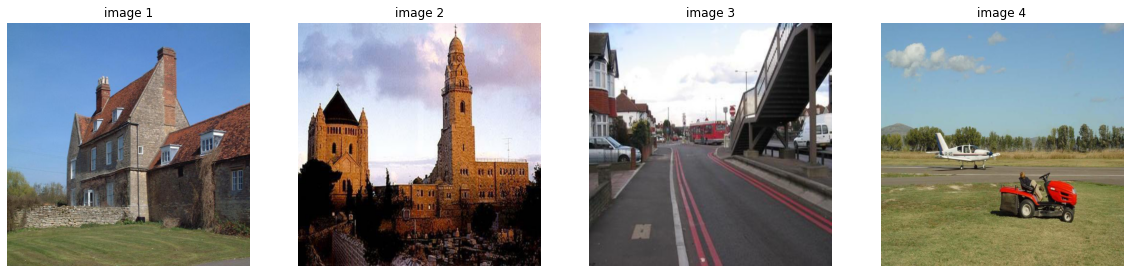

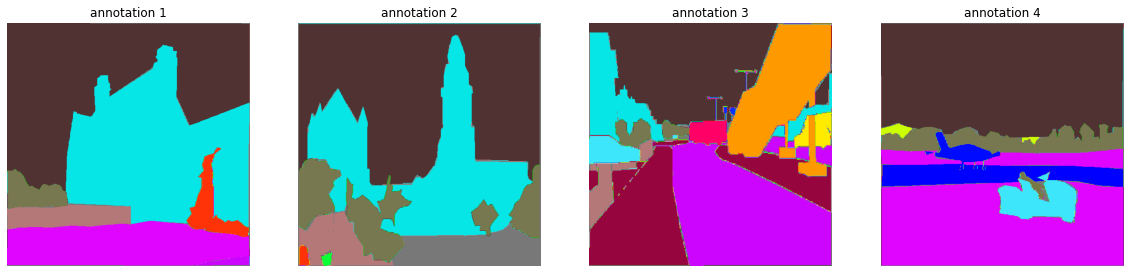

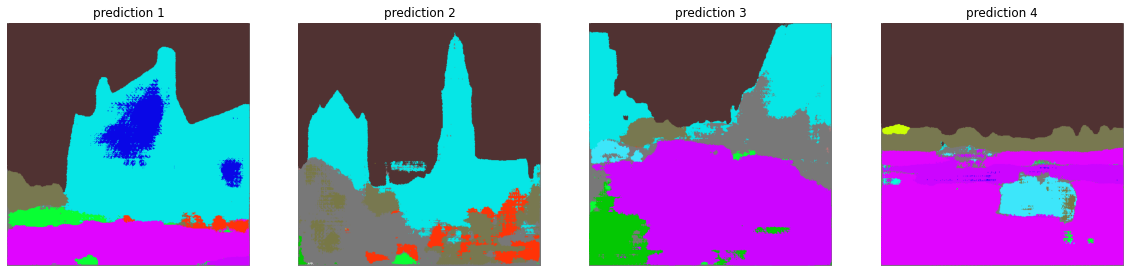

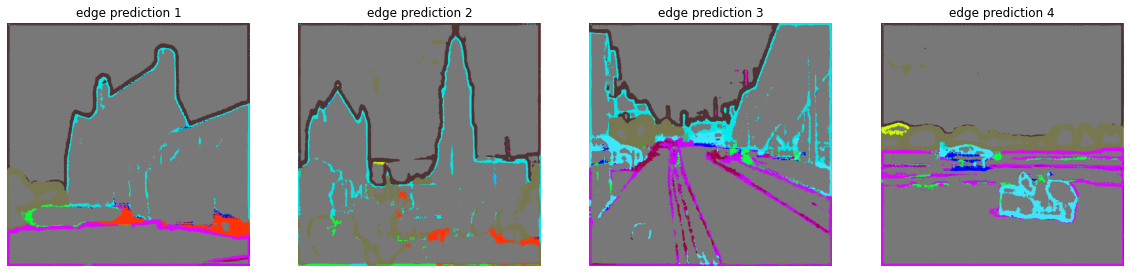

In [45]:
img, mask = next(iter(validation_data_loader))

visualize_prediction_edge_n(img, mask, 4, net, edge_net)

## Evaluate Model Performance

### Piexel Accuracy & IOU

In [32]:
validation_data = DataLoaderSegmentation(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 2)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  63


In [20]:
def intersectionAndUnion(imPred, imLab, numClass):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()

    imPred += 1
    imLab += 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab > 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    return (area_intersection, area_union)

In [21]:
def accuracy(preds, label):
    valid = (label >= 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (valid_sum + 1e-10)
    return acc, valid_sum

In [23]:
def evaluate(model, edge_model, loader):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    intersection_meter_50 = AverageMeter()
    union_meter_50 = AverageMeter()


    model.eval()
    edge_model.eval()

    for img, seg in tqdm(validation_data_loader):
        # get the prediction here
        edge_pred = edge_model(img.to(device))
        pred = model(img.to(device), edge_pred)
        pred = pred.detach().cpu()
        pred = np.argmax(pred, axis = 1)

        # calculate accuracy
        acc, pix = accuracy(pred, seg)
        intersection, union = intersectionAndUnion(pred, seg, 151)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)
        intersection_meter_50.update(intersection[0:50])
        union_meter_50.update(union[0:50])


    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    iou_50 = intersection_meter_50.sum / (union_meter_50.sum + 1e-10)
    f= open("/content/iou_baseline.txt","w+")
    for i, _iou in enumerate(iou):
      print('class [{}], IoU: {:.4f}'.format(i, _iou))
      f.write('{}, {:.4f}'.format(i, _iou))
      f.write('\n')

    print('[Eval Summary]:')
    print('Mean IoU: {:.4f}, Mean IoU first 50 classes: {:.4f}, Accuracy: {:.4f}%'
          .format(iou.mean(), iou_50.mean(), acc_meter.average()*100))


In [33]:
evaluate(net, edge_net, validation_data_loader)

  0%|          | 0/63 [00:00<?, ?it/s]

class [0], IoU: 0.1626
class [1], IoU: 0.5535
class [2], IoU: 0.5171
class [3], IoU: 0.8227
class [4], IoU: 0.5655
class [5], IoU: 0.5493
class [6], IoU: 0.6557
class [7], IoU: 0.4864
class [8], IoU: 0.6042
class [9], IoU: 0.3986
class [10], IoU: 0.4562
class [11], IoU: 0.2246
class [12], IoU: 0.0300
class [13], IoU: 0.3871
class [14], IoU: 0.1723
class [15], IoU: 0.0983
class [16], IoU: 0.2149
class [17], IoU: 0.2522
class [18], IoU: 0.3011
class [19], IoU: 0.3474
class [20], IoU: 0.2501
class [21], IoU: 0.1714
class [22], IoU: 0.1527
class [23], IoU: 0.4241
class [24], IoU: 0.1280
class [25], IoU: 0.0869
class [26], IoU: 0.1514
class [27], IoU: 0.3065
class [28], IoU: 0.1017
class [29], IoU: 0.2323
class [30], IoU: 0.0303
class [31], IoU: 0.0091
class [32], IoU: 0.0132
class [33], IoU: 0.0000
class [34], IoU: 0.0045
class [35], IoU: 0.0024
class [36], IoU: 0.0823
class [37], IoU: 0.2470
class [38], IoU: 0.2031
class [39], IoU: 0.0000
class [40], IoU: 0.1583
class [41], IoU: 0.0000
cl

In [22]:
def multi_acc(pred, label):
    pred = np.argmax(pred, axis = 1)
    corrects = (pred == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [27]:
def evaluate_model(model, edge_model, val_loader, eval_func):
  model.eval()
  step = len(val_loader)
  acc = []
  with torch.no_grad():
    for img, seg in tqdm(val_loader):
      img = img.to(device)
      edge_raw = edge_net(img)
      prediction_raw = model(img, edge_raw)
      acc.append(eval_func(prediction_raw.cpu(), seg))
  return np.mean(acc)

In [28]:
evaluate_model(net, edge_net, validation_data_loader, multi_acc)

  0%|          | 0/250 [00:00<?, ?it/s]

56.563034

### Plot Loss

In [37]:
# plot training loss and validation loss
import matplotlib.pyplot as plt
def plot_train_val_loss(epoch_loss_values, val_loss_values, file_name):
  plt.plot(np.arange(len(epoch_loss_values))+1, epoch_loss_values, label = "training")
  plt.xlabel("Epoch")
  # plt.ylabel("Training Cross-Entropy Loss")
  plt.plot(np.arange(len(val_loss_values))+1, val_loss_values, label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-Entropy Loss")
  plt.title(file_name)
  plt.legend()
  plt.savefig(fname = file_name)

In [40]:
train_loss_values = [3.1024257052256208, 2.708772419561777, 2.5468861196405435, 2.424933458497764, 2.3220115387052744, 
2.242242352908694, 2.1811881345694535, 2.1357049627239895, 2.088721697092623, 2.049179104307957, 
2.0091735084710005, 1.974963656561014, 1.940267090252818, 1.9074129993162359, 1.8710313960850853, 
1.8402666948611832, 1.8120449471596396, 1.78400558207305, 1.7549938924097392, 1.7290665675795276, 
1.7019221405848943, 1.6757032287941975, 1.64785004556415, 1.6222490322372787, 1.5985040207137593, 
1.576608507362322, 1.5501869635410188, 1.529740486202595, 1.5098907499915537, 1.4891679283181354 ]

val_loss_values = [2.8386526851654055, 2.6208914904594423, 2.4832545313835146, 2.321325898170471, 2.361612648010254, 
2.2452951455116272, 2.2237707777023314, 2.126517930030823, 2.123274182319641, 2.0612224144935607, 
2.0293211512565614, 2.0095294547080993, 2.0711531167030333, 2.0043419675827026, 2.020233375787735, 
1.9378231337070466, 1.8971950607299806, 1.8743104619979858, 1.8831177320480346, 1.8773889491558076, 
1.8371984889507293, 1.8580364844799042, 1.8514094877243041, 1.8645696454048157, 1.818522552728653, 
1.8746472234725953, 1.8099628026485444, 1.7971720056533813, 1.7835287182331085, 1.7861333611011505]

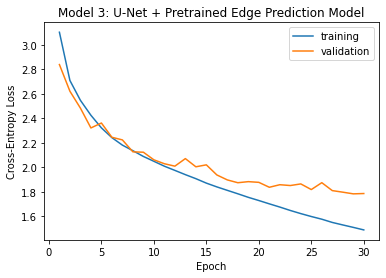

In [41]:
plot_train_val_loss(train_loss_values, val_loss_values, "Model 3: U-Net + Pretrained Edge Prediction Model")